cifar10 patch reconstruction using stochastic interpolants

this implementation:
- trains on dog class only (cifar10 class 5)
- uses mask-conditioned u-net architecture
- learns to reconstruct masked patches while keeping visible pixels fixed
- conditions on mask during both training and generation
- forces visible pixels to remain constant in output

approach:
  x0 = masked_image * mask + noise * (1-mask)  # we start with visible pixels + noise in masked regions
  x1 = original_image                           # we target full image
  model learns interpolant: x0 -> x1 conditioned on mask
  during generation: output = model_output * (1-mask) + original * mask  # we force visible pixels fixed

In [9]:

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../../')
from typing import Tuple, Any

import interflow as itf
import interflow.stochastic_interpolant as stochastic_interpolant

if torch.cuda.is_available():
    print('cuda available, setting default tensor residence to gpu')
    itf.util.set_torch_device('cuda')
else:
    print('no cuda device found')
print(itf.util.get_torch_device())

print("torch version:", torch.__version__)

cuda available, setting default tensor residence to gpu
cuda
torch version: 2.9.0+cu128


we define utility functions

In [10]:
def grab(var):
    """we take a tensor off the gpu and convert it to a numpy array on the cpu"""
    return var.detach().cpu().numpy()

we load cifar10 dataset

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="../../data/cifar10", train=True, 
                                        download=True, transform=transform)

# we filter dataset to keep only dog class (class 5)
# cifar10 classes: 0=airplane, 1=automobile, 2=bird, 3=cat, 4=deer, 5=dog, 6=frog, 7=horse, 8=ship, 9=truck
target_class = 5  # we select dog class
dog_indices = [i for i in range(len(trainset)) if trainset.targets[i] == target_class]
print(f"\nfiltered dataset to class 'dog': {len(dog_indices)} images (out of {len(trainset)} total)")

# we create data iterator that only samples from dog images
def get_cifar_batch(bs):
    """we get a batch of cifar10 dog images only"""
    indices = torch.randint(0, len(dog_indices), (bs,))
    imgs = torch.stack([trainset[dog_indices[i]][0] for i in indices])
    return imgs.to(itf.util.get_torch_device())

# we create masking function for patches
def create_patch_mask(bs, patch_size=8, num_patches=4):
    """we create random patch masks, 1 for visible pixels, 0 for masked patches"""
    mask = torch.ones(bs, 3, 32, 32)
    for i in range(bs):
        for _ in range(num_patches):
            x = torch.randint(0, 32 - patch_size, (1,)).item()
            y = torch.randint(0, 32 - patch_size, (1,)).item()
            mask[i, :, x:x+patch_size, y:y+patch_size] = 0  # we mask the patch
    return mask.to(itf.util.get_torch_device())


filtered dataset to class 'dog': 5000 images (out of 50000 total)


we define u-net style convolutional denoiser for image reconstruction

In [12]:
class UNetDenoiser(nn.Module):
    """we use u-net architecture with skip connections for image reconstruction, conditioned on mask"""
    def __init__(self, in_channels=5, out_channels=3, base_channels=64):  # we add 1 channel for mask conditioning
        super().__init__()
        
        # we define encoder (downsampling path)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        
        # we define bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_channels*8),
            nn.ReLU(),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.GroupNorm(8, base_channels*8),
            nn.ReLU()
        )
        
        # we define decoder (upsampling path) with skip connections
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        self.dec3_conv = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU(),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.GroupNorm(8, base_channels*4),
            nn.ReLU()
        )
        
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        self.dec2_conv = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU(),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.GroupNorm(8, base_channels*2),
            nn.ReLU()
        )
        
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2, base_channels, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        self.dec1_conv = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.GroupNorm(8, base_channels),
            nn.ReLU()
        )
        
        # we define final output layer
        self.final = nn.Conv2d(base_channels, out_channels, 1)
    
    def forward(self, x_with_t):
        """we forward pass with skip connections"""
        # we encode
        e1 = self.enc1(x_with_t)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # we process bottleneck
        b = self.bottleneck(e3)
        
        # we decode with skip connections
        d3 = self.dec3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3_conv(d3)
        
        d2 = self.dec2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2_conv(d2)
        
        d1 = self.dec1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1_conv(d1)
        
        # we output final reconstruction
        out = self.final(d1)
        return out

we define wrapper for eta network to match expected interface

In [13]:
class EtaNetwork(nn.Module):
    """we wrap unet to accept concatenated [x, t, mask] input"""
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
        self.mask = None  # we store mask for conditioning
    
    def set_mask(self, mask):
        """we set the mask for conditioning"""
        self.mask = mask
    
    def forward(self, xt, t=None):
        """we support xt with or without appended time; t may be provided separately"""
        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # we ensure batch dimension
        bs = xt.shape[0]
        feat_dim = xt.shape[1]
        expected_x_dim = 3 * 32 * 32  # we expected flattened image dim
        
        if feat_dim == expected_x_dim + 1:
            x_flat = xt[:, :-1]  # we split x and t when t is appended
            t_vec = xt[:, -1:].to(device=xt.device, dtype=xt.dtype)  # we take t from input
        elif feat_dim == expected_x_dim:
            if t is None:
                raise RuntimeError("t must be provided when xt has no appended time")  # we enforce presence of t
            if not isinstance(t, torch.Tensor):
                t_vec = torch.tensor(t, device=xt.device, dtype=xt.dtype)  # we wrap python scalar/array
            else:
                t_vec = t.to(device=xt.device, dtype=xt.dtype)  # we move to same device/dtype
            numel = t_vec.numel()
            if numel == 1:
                t_vec = t_vec.reshape(1, 1).expand(bs, 1)  # we broadcast single time to batch
            elif numel == bs:
                t_vec = t_vec.reshape(bs, 1)  # we ensure shape [bs,1]
            else:
                raise RuntimeError(f"t has {numel} elements; expected 1 or {bs}")  # we guard invalid sizes
            x_flat = xt  # we use full vector as x
        else:
            raise RuntimeError(f"unexpected feature dimension {feat_dim}; expected {expected_x_dim} or {expected_x_dim+1}")  # we guard invalid dims
        
        x = x_flat.reshape(bs, 3, 32, 32)  # we reshape to image
        t_channel = t_vec.view(bs, 1, 1, 1).expand(bs, 1, 32, 32)  # we spatially broadcast t
        
        # we add mask conditioning (use first channel of mask for simplicity)
        if self.mask is not None:
            mask_channel = self.mask[:bs, 0:1, :, :]  # we take first channel of mask [bs, 1, 32, 32]
        else:
            mask_channel = torch.ones(bs, 1, 32, 32, device=x.device)  # we default to all visible
        
        x_with_t_mask = torch.cat([x, t_channel, mask_channel], dim=1)  # we concatenate [x, t, mask]
        
        # we process through unet
        out = self.unet(x_with_t_mask)
        
        # we flatten output
        return out.reshape(bs, -1)

# we define velocity field wrapper
class VelocityNetwork(nn.Module):
    """we wrap unet for velocity field b, conditioned on mask"""
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
        self.mask = None  # we store mask for conditioning
    
    def set_mask(self, mask):
        """we set the mask for conditioning"""
        self.mask = mask
    
    def forward(self, xt, t=None):
        """we support xt with or without appended time; t may be provided separately"""
        if xt.dim() == 1:
            xt = xt.unsqueeze(0)  # we ensure batch dimension
        bs = xt.shape[0]
        feat_dim = xt.shape[1]
        expected_x_dim = 3 * 32 * 32  # we expected flattened image dim
        
        if feat_dim == expected_x_dim + 1:
            x_flat = xt[:, :-1]  # we split x and t when t is appended
            t_vec = xt[:, -1:].to(device=xt.device, dtype=xt.dtype)  # we take t from input
        elif feat_dim == expected_x_dim:
            if t is None:
                raise RuntimeError("t must be provided when xt has no appended time")  # we enforce presence of t
            if not isinstance(t, torch.Tensor):
                t_vec = torch.tensor(t, device=xt.device, dtype=xt.dtype)  # we wrap python scalar/array
            else:
                t_vec = t.to(device=xt.device, dtype=xt.dtype)  # we move to same device/dtype
            numel = t_vec.numel()
            if numel == 1:
                t_vec = t_vec.reshape(1, 1).expand(bs, 1)  # we broadcast single time to batch
            elif numel == bs:
                t_vec = t_vec.reshape(bs, 1)  # we ensure shape [bs,1]
            else:
                raise RuntimeError(f"t has {numel} elements; expected 1 or {bs}")  # we guard invalid sizes
            x_flat = xt  # we use full vector as x
        else:
            raise RuntimeError(f"unexpected feature dimension {feat_dim}; expected {expected_x_dim} or {expected_x_dim+1}")  # we guard invalid dims
        
        x = x_flat.reshape(bs, 3, 32, 32)  # we reshape to image
        t_channel = t_vec.view(bs, 1, 1, 1).expand(bs, 1, 32, 32)  # we spatially broadcast t
        
        # we add mask conditioning (use first channel of mask for simplicity)
        if self.mask is not None:
            mask_channel = self.mask[:bs, 0:1, :, :]  # we take first channel of mask [bs, 1, 32, 32]
        else:
            mask_channel = torch.ones(bs, 1, 32, 32, device=x.device)  # we default to all visible
        
        x_with_t_mask = torch.cat([x, t_channel, mask_channel], dim=1)  # we concatenate [x, t, mask]
        
        # we process through unet
        out = self.unet(x_with_t_mask)
        
        # we flatten output
        return out.reshape(bs, -1)

we define training step function

In [14]:
def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b: Any,
    opt_eta: Any,
    sched_b: Any,
    sched_eta: Any,
    patch_size: int,
    num_patches: int,
    mask_loss_weight: float = 10.0
):
    """we take a single step of optimization on the training set"""
    opt_b.zero_grad()
    opt_eta.zero_grad()
    
    # we construct batch of real images
    x1s_img = get_cifar_batch(bs)  # we get [bs, 3, 32, 32]
    
    # we create masks
    masks = create_patch_mask(bs, patch_size=patch_size, num_patches=num_patches)  # we get [bs, 3, 32, 32]
    
    # we create masked images + noise in masked regions as starting point
    noise = torch.randn_like(x1s_img) * (1 - masks)  # we add noise only in masked regions
    x0s_img = x1s_img * masks + noise  # we combine masked image and noise
    
    # we flatten for interpolant
    x0s = x0s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    x1s = x1s_img.reshape(bs, -1)  # we flatten to [bs, 3072]
    masks_flat = masks.reshape(bs, -1)  # we flatten mask too
    
    # we sample random times
    ts = torch.rand(size=(bs,)).to(itf.util.get_torch_device())
    
    # we set masks for conditioning in both networks
    b.set_mask(masks)
    eta.set_mask(masks)
    
    # we compute the losses
    loss_start = time.perf_counter()
    loss_b_full = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_eta_full = loss_fn_eta(eta, x0s, x1s, ts, interpolant)
    
    # we weight the loss to focus on masked regions (multiply by mask_loss_weight for masked pixels)
    # we compute per-pixel weight: visible pixels get weight 1.0, masked pixels get weight mask_loss_weight
    loss_weights = masks_flat + mask_loss_weight * (1 - masks_flat)  # we create per-pixel weights
    
    # we apply weighted loss (approximation: we multiply total loss by average weight)
    avg_weight = loss_weights.mean()
    loss_b = loss_b_full * avg_weight
    loss_eta = loss_eta_full * avg_weight
    
    loss_val = loss_b + loss_eta
    loss_end = time.perf_counter()
    
    # we compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_eta.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    eta_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(eta.parameters(), float('inf'))])
    backprop_end = time.perf_counter()
    
    # we perform the update
    update_start = time.perf_counter()
    opt_b.step()
    opt_eta.step()
    sched_b.step()
    sched_eta.step()
    update_end = time.perf_counter()
    
    if counter < 5:
        print(f'[loss: {loss_end - loss_start:.4f}s], [backprop: {backprop_end-backprop_start:.4f}s], [update: {update_end-update_start:.4f}s]')
    
    return loss_val.detach(), loss_b.detach(), loss_eta.detach(), b_grad.detach(), eta_grad.detach()

we define visualization function

In [15]:
def make_plots(
    b: torch.nn.Module,
    eta: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    counter: int,
    data_dict: dict,
    patch_size: int,
    num_patches: int
):
    """we make plots to visualize reconstruction results"""
    print(f"\nepoch: {counter}")
    
    # we get a batch for visualization
    vis_bs = 4
    x1s_img = get_cifar_batch(vis_bs)
    masks = create_patch_mask(vis_bs, patch_size=patch_size, num_patches=num_patches)
    
    # we create masked images
    noise = torch.randn_like(x1s_img) * (1 - masks)
    x0s_img = x1s_img * masks + noise
    
    # we reconstruct using probability flow
    x0s = x0s_img.reshape(vis_bs, -1)
    x1s = x1s_img.reshape(vis_bs, -1)
    
    # we use simple forward integration
    with torch.no_grad():
        # we set masks for conditioning during generation
        b.set_mask(masks)
        eta.set_mask(masks)
        
        s = stochastic_interpolant.SFromEta(eta, interpolant.a)
        pflow = stochastic_interpolant.PFlowIntegrator(
            b=b, method='rk4', interpolant=interpolant, n_step=5, sample_only=True
        )
        xfs_pflow, _ = pflow.rollout(x0s)
        xf_pflow_raw = xfs_pflow[-1].reshape(vis_bs, 3, 32, 32)
        
        # we force visible pixels to remain fixed (only reconstruct masked regions)
        xf_pflow = xf_pflow_raw * (1 - masks) + x1s_img * masks  # we keep original pixels where mask=1
    
    # we plot results
    fig, axes = plt.subplots(3, vis_bs, figsize=(vis_bs*2, 6))
    
    for i in range(vis_bs):
        # we denormalize images for visualization
        def denorm(img):
            return img * 0.5 + 0.5
        
        # we show original image
        axes[0, i].imshow(np.transpose(grab(denorm(x1s_img[i])), (1, 2, 0)))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('original', fontsize=10)
        
        # we show masked image
        axes[1, i].imshow(np.transpose(grab(denorm(x0s_img[i])), (1, 2, 0)))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('masked', fontsize=10)
        
        # we show reconstructed image
        axes[2, i].imshow(np.transpose(grab(denorm(xf_pflow[i])), (1, 2, 0)))
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title('reconstructed', fontsize=10)
    
    plt.suptitle(f'dog patch reconstruction - epoch {counter}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(f'dog_reconstruction_epoch_{counter}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # we plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    epochs = np.arange(len(data_dict['losses'])) * metrics_freq
    
    # we plot losses
    axes[0].plot(epochs, data_dict['losses'], label='total loss', linewidth=2)
    axes[0].plot(epochs, data_dict['b_losses'], label='b loss', alpha=0.7)
    axes[0].plot(epochs, data_dict['eta_losses'], label='eta loss', alpha=0.7)
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('loss')
    axes[0].set_title('training loss (dog class)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # we plot gradients
    axes[1].plot(epochs, data_dict['b_grads'], label='b grad norm', linewidth=2)
    axes[1].plot(epochs, data_dict['eta_grads'], label='eta grad norm', linewidth=2)
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('gradient norm')
    axes[1].set_title('gradient norms')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # we plot learning rates
    axes[2].plot(epochs, data_dict['lrs'], label='learning rate', linewidth=2)
    axes[2].set_xlabel('epoch')
    axes[2].set_ylabel('learning rate')
    axes[2].set_title('learning rate schedule')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'dog_training_curves_epoch_{counter}.png', dpi=150, bbox_inches='tight')
    plt.show()

we define main training setup

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67509353..2.1645439].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69873714..2.0235038].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0015018..1.7459123].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.100895..2.4312406].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0316244..1.934623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0999187..2.3310742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.882766


hyperparameters:
  class: dog (cifar10 class 5)
  batch_size: 32
  learning_rate: 0.0001
  n_epochs: 10000
  patch_size: 4
  num_patches: 4

conditioning approach:
  - networks conditioned on binary mask (visible=1, masked=0)
  - visible pixels kept fixed during generation
  - only masked regions are reconstructed

using interpolant: one-sided-linear

creating u-net architectures with mask conditioning...
b network parameters: 8,565,315
eta network parameters: 8,565,315

starting training...

[loss: 0.0034s], [backprop: 0.0166s], [update: 0.0066s]
epoch 1: loss=1358.0972, b_loss=478.9716, eta_loss=879.1256

epoch: 1


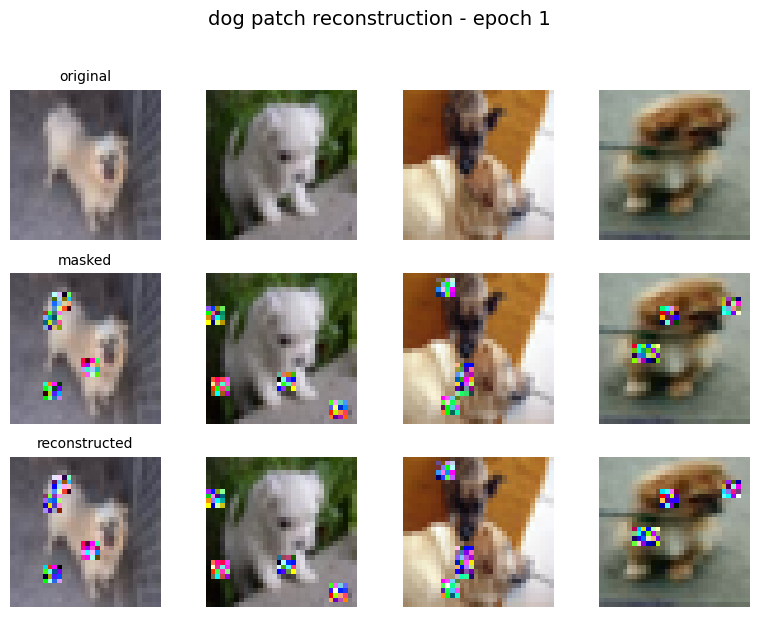

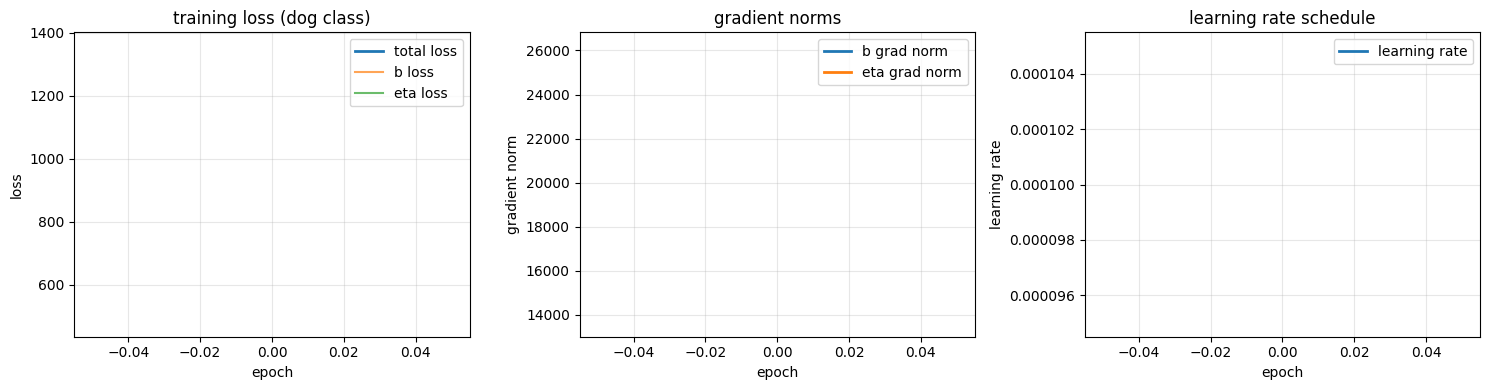

saved checkpoint at epoch 1
[loss: 0.0031s], [backprop: 0.0170s], [update: 0.0042s]
[loss: 0.0026s], [backprop: 0.0173s], [update: 0.0042s]
[loss: 0.0026s], [backprop: 0.0173s], [update: 0.0042s]
epoch 101: loss=-623.4681, b_loss=-42.7553, eta_loss=-580.7128
epoch 201: loss=-748.6884, b_loss=-121.2839, eta_loss=-627.4045
epoch 301: loss=-869.4265, b_loss=-119.4661, eta_loss=-749.9604
epoch 401: loss=-762.2559, b_loss=-115.0802, eta_loss=-647.1756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2138367..1.6486311].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08904189..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85220563..1.6626238].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7745086..1.4963821].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72281265..1.9197165].


epoch 501: loss=-789.5659, b_loss=-120.0339, eta_loss=-669.5319

epoch: 501


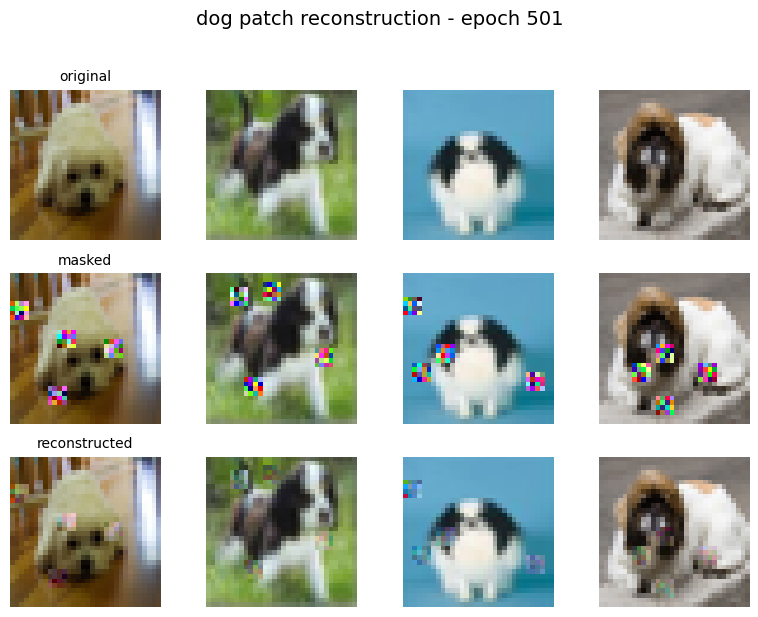

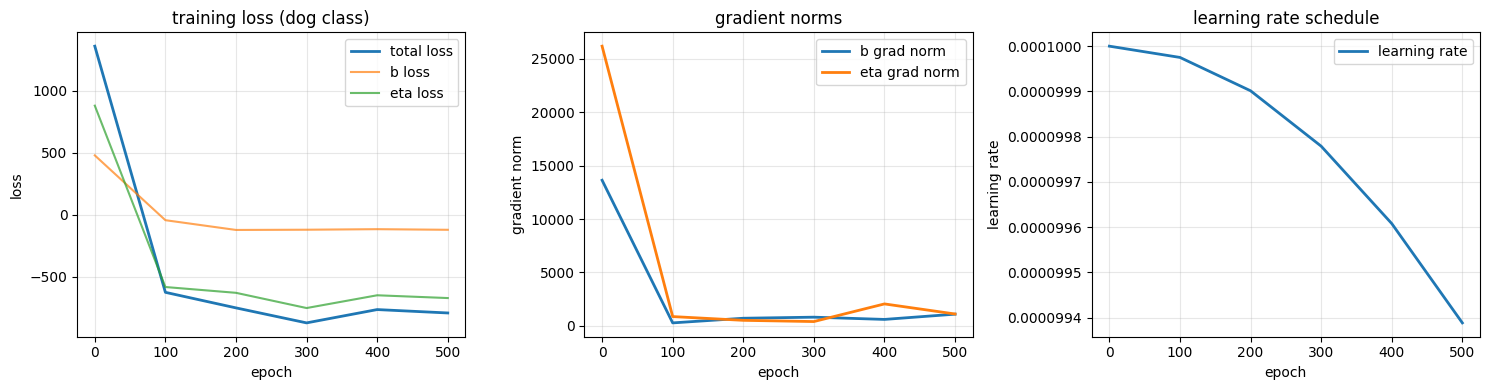

saved checkpoint at epoch 501
epoch 601: loss=-778.6284, b_loss=-130.2572, eta_loss=-648.3712
epoch 701: loss=-794.5630, b_loss=-134.0388, eta_loss=-660.5242
epoch 801: loss=-832.5320, b_loss=-139.5055, eta_loss=-693.0265
epoch 901: loss=-712.6241, b_loss=-117.4735, eta_loss=-595.1506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6298064..1.6623217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0279301..1.795308].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82741797..1.9111772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24155408..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9800199..2.4075937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10055727..0.682957].


epoch 1001: loss=-744.5813, b_loss=-121.1517, eta_loss=-623.4296

epoch: 1001


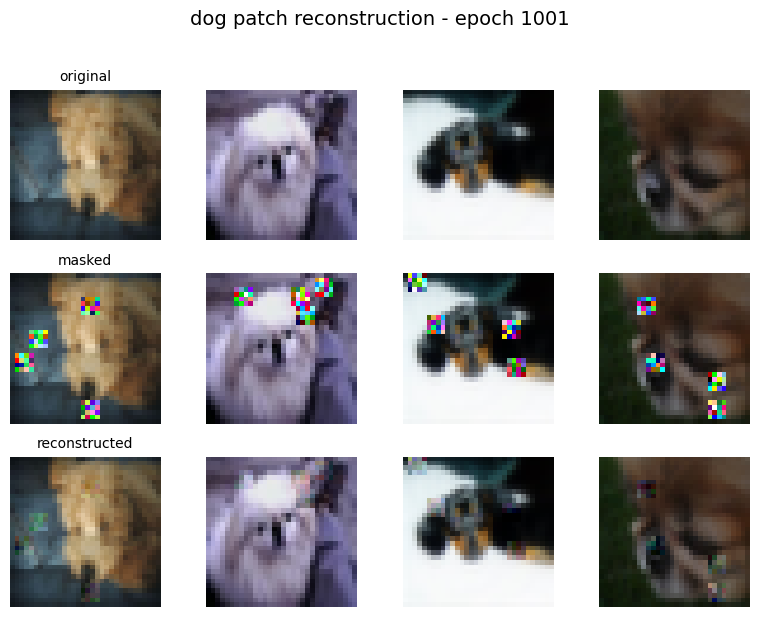

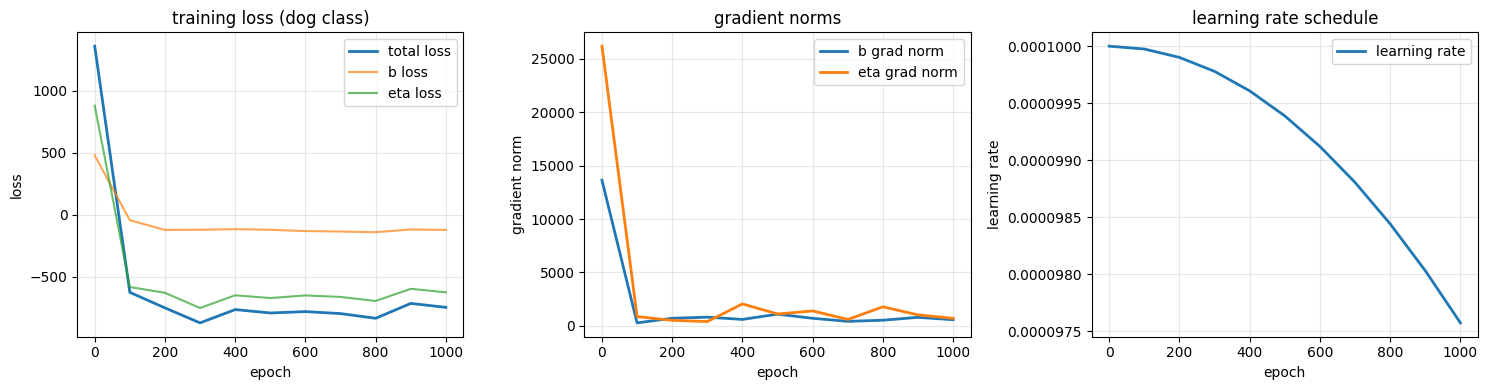

saved checkpoint at epoch 1001
epoch 1101: loss=-821.0831, b_loss=-150.6180, eta_loss=-670.4652
epoch 1201: loss=-770.5851, b_loss=-149.1888, eta_loss=-621.3963
epoch 1301: loss=-846.9216, b_loss=-148.6225, eta_loss=-698.2991
epoch 1401: loss=-804.0902, b_loss=-151.5202, eta_loss=-652.5700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.82297456..1.5994273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0088899].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1219283..1.8225095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74317527..1.7292355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0150828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6633949..1.9871757].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.016230911..1.064198

epoch 1501: loss=-809.2339, b_loss=-147.4728, eta_loss=-661.7611

epoch: 1501


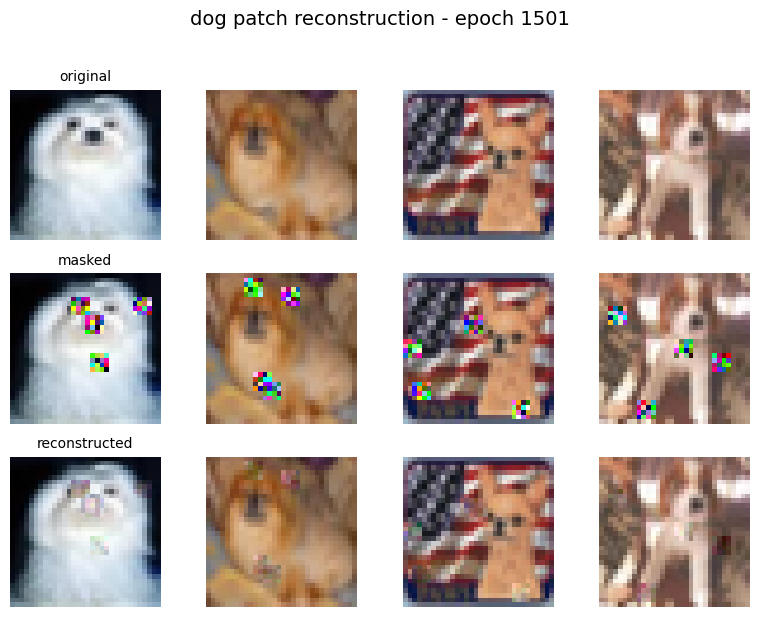

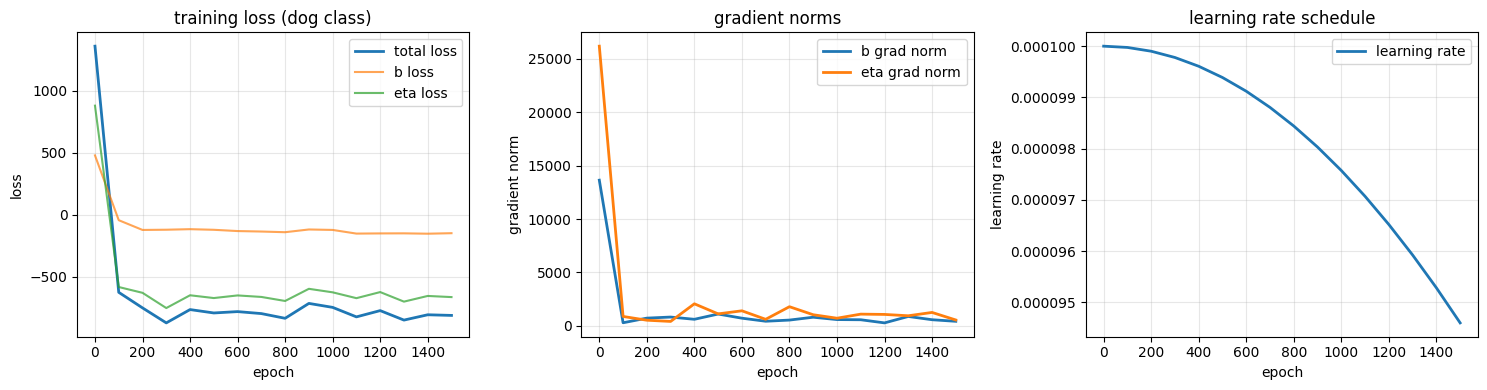

saved checkpoint at epoch 1501
epoch 1601: loss=-821.3828, b_loss=-140.1497, eta_loss=-681.2331
epoch 1701: loss=-859.9379, b_loss=-138.2068, eta_loss=-721.7310
epoch 1801: loss=-793.0047, b_loss=-137.3491, eta_loss=-655.6556
epoch 1901: loss=-833.5150, b_loss=-146.9934, eta_loss=-686.5217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67652106..1.9780725].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64502645..1.8601606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450979..1.2545037].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5575876..1.7643114].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7659228..1.754052].


epoch 2001: loss=-759.4331, b_loss=-137.2487, eta_loss=-622.1844

epoch: 2001


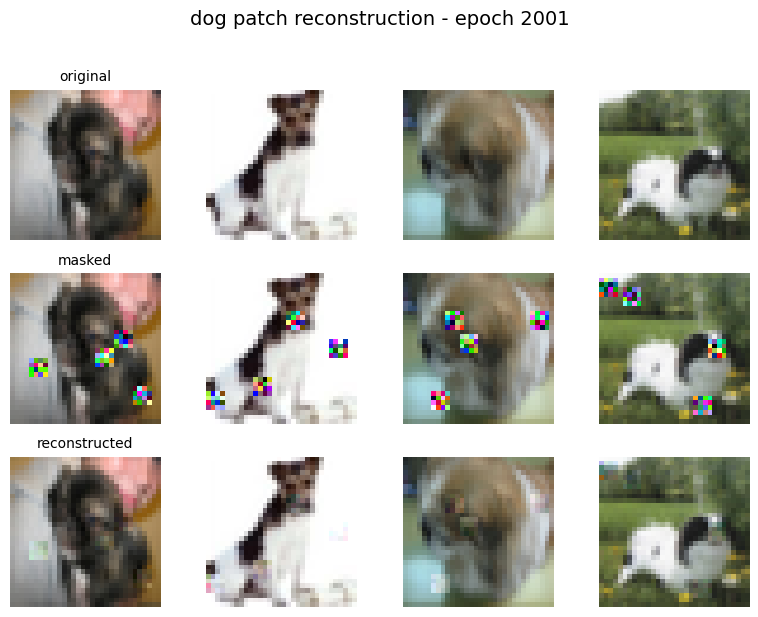

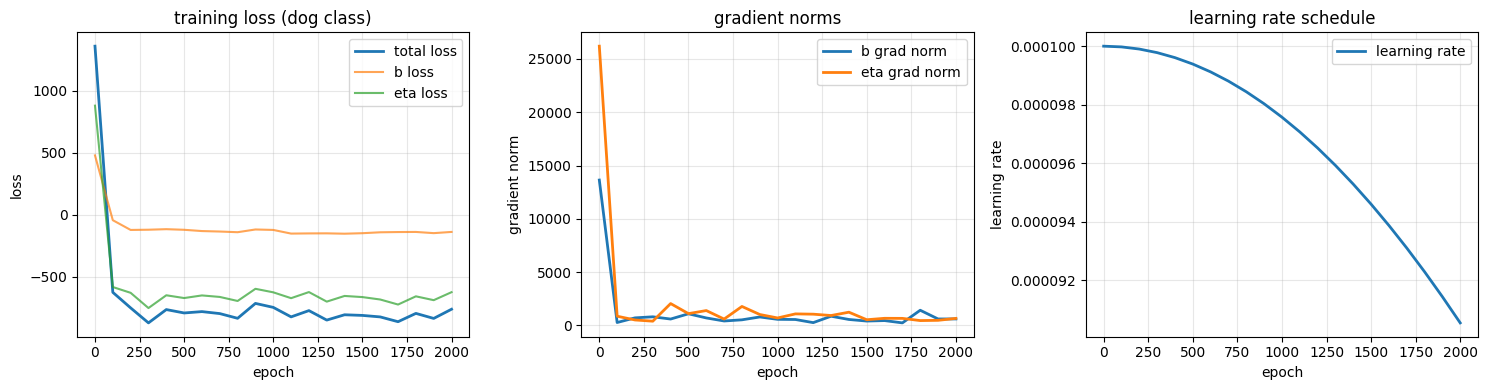

saved checkpoint at epoch 2001
epoch 2101: loss=-890.6945, b_loss=-151.6128, eta_loss=-739.0816
epoch 2201: loss=-802.1702, b_loss=-137.5878, eta_loss=-664.5823
epoch 2301: loss=-821.6780, b_loss=-135.8863, eta_loss=-685.7917
epoch 2401: loss=-832.6577, b_loss=-150.3333, eta_loss=-682.3244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94334793..2.386307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098039..1.0012069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8407718..2.0683467].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054290175..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98179877..2.1545992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.83003974..1.8127192].


epoch 2501: loss=-839.2603, b_loss=-144.3597, eta_loss=-694.9006

epoch: 2501


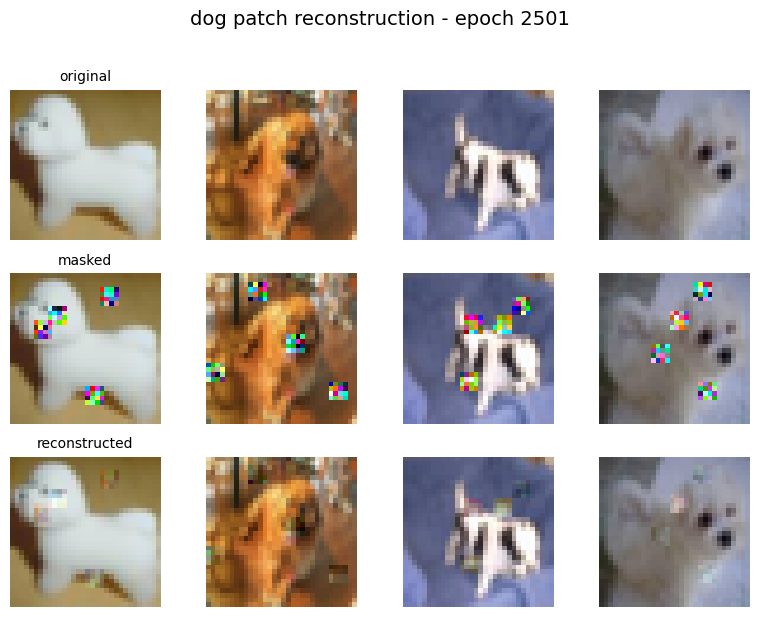

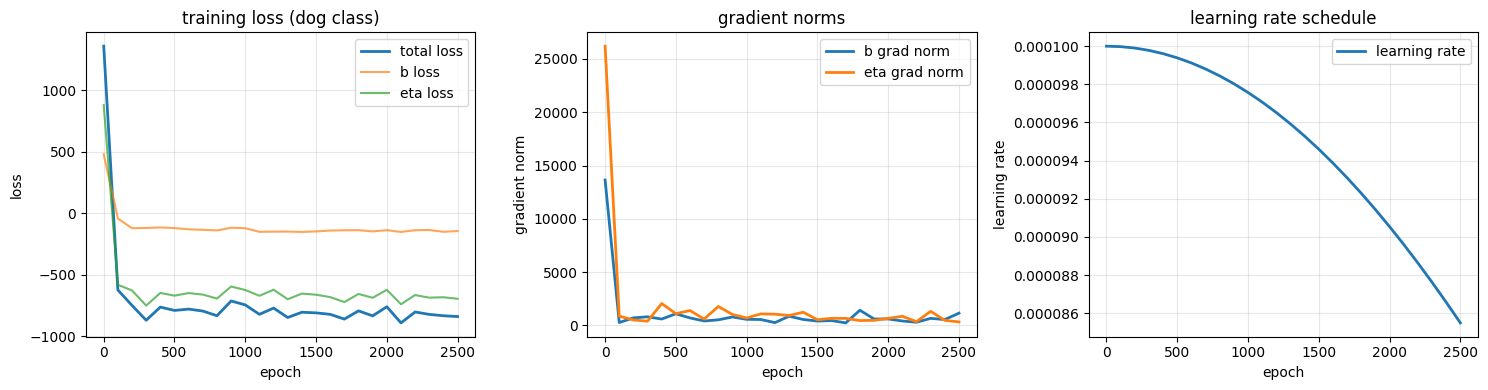

saved checkpoint at epoch 2501
epoch 2601: loss=-856.5446, b_loss=-152.7515, eta_loss=-703.7930
epoch 2701: loss=-774.8654, b_loss=-151.6843, eta_loss=-623.1811
epoch 2801: loss=-782.6584, b_loss=-143.4456, eta_loss=-639.2129
epoch 2901: loss=-786.1611, b_loss=-139.9503, eta_loss=-646.2108


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63391876..1.7834274].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0931405..1.7022005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.058823526..1.1023946].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76693714..1.7683437].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.082352936..1.0709312].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8189447..1.6602389].


epoch 3001: loss=-870.6168, b_loss=-146.2729, eta_loss=-724.3439

epoch: 3001


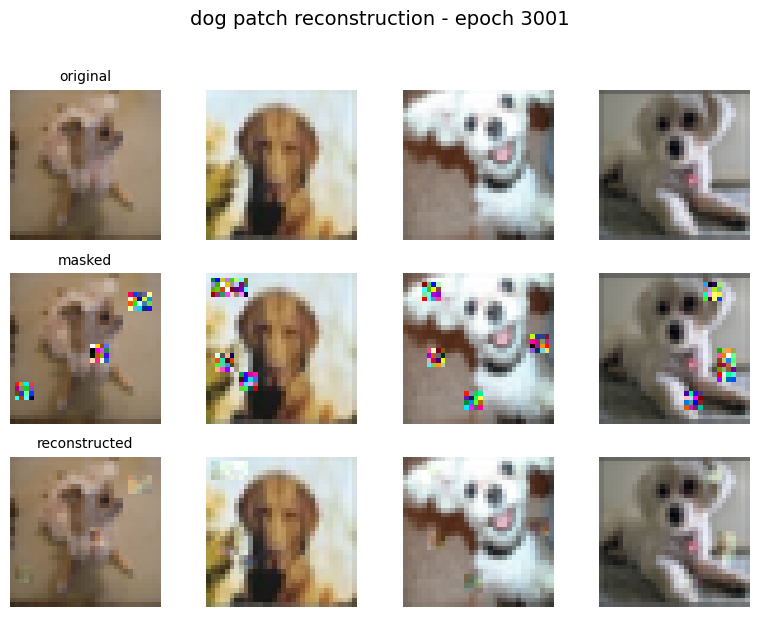

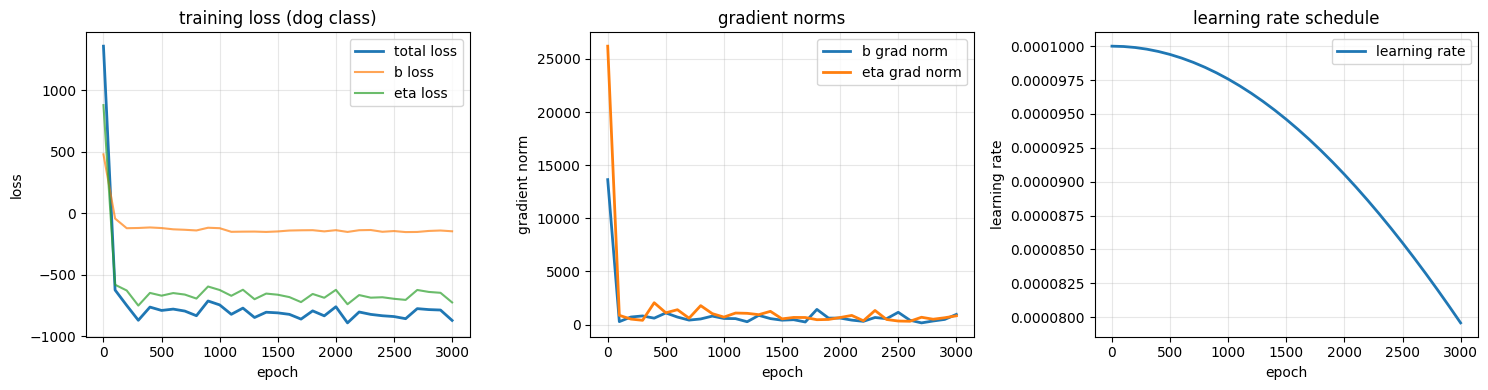

saved checkpoint at epoch 3001
epoch 3101: loss=-918.2226, b_loss=-164.3475, eta_loss=-753.8751
epoch 3201: loss=-858.9596, b_loss=-163.7466, eta_loss=-695.2130
epoch 3301: loss=-835.0010, b_loss=-161.2648, eta_loss=-673.7362
epoch 3401: loss=-888.7869, b_loss=-150.1751, eta_loss=-738.6119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6445699..1.7916932].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7668172..1.6821631].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75937366..1.4538794].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6406306..1.6010742].


epoch 3501: loss=-885.1810, b_loss=-160.9514, eta_loss=-724.2296

epoch: 3501


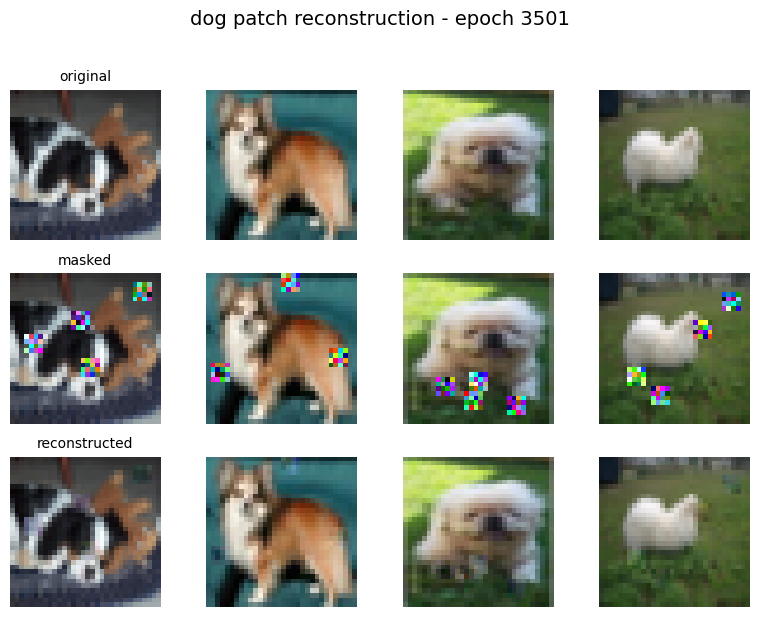

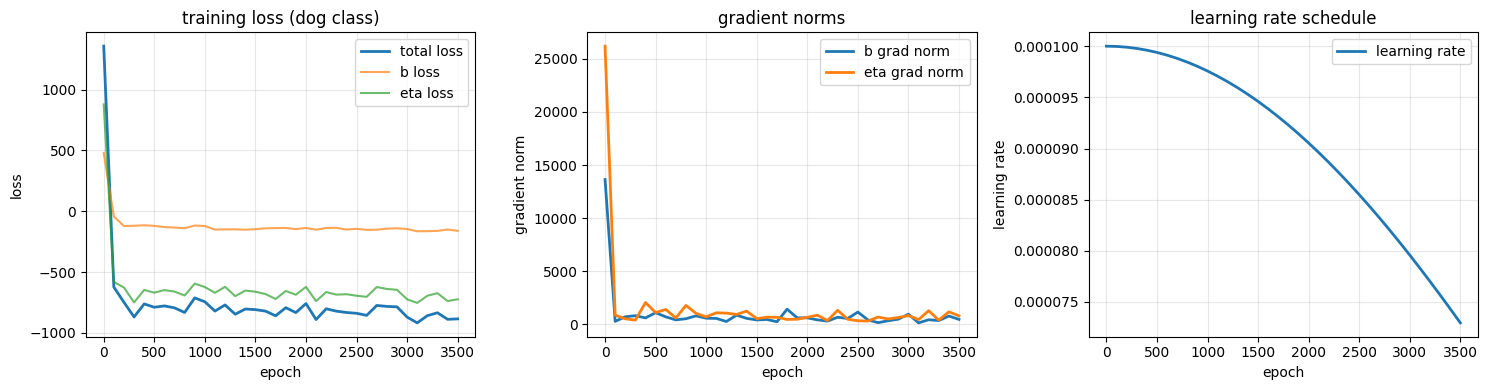

saved checkpoint at epoch 3501
epoch 3601: loss=-861.7969, b_loss=-150.0939, eta_loss=-711.7030
epoch 3701: loss=-850.5472, b_loss=-151.8548, eta_loss=-698.6924
epoch 3801: loss=-798.8889, b_loss=-146.2819, eta_loss=-652.6069
epoch 3901: loss=-802.7858, b_loss=-143.7041, eta_loss=-659.0817


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1380686..1.7391742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09411764..1.0296345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85997856..1.8801703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92259943..1.7624663].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.031372547..1.044811].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0163901..1.753031].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02250

epoch 4001: loss=-851.9338, b_loss=-161.7128, eta_loss=-690.2211

epoch: 4001


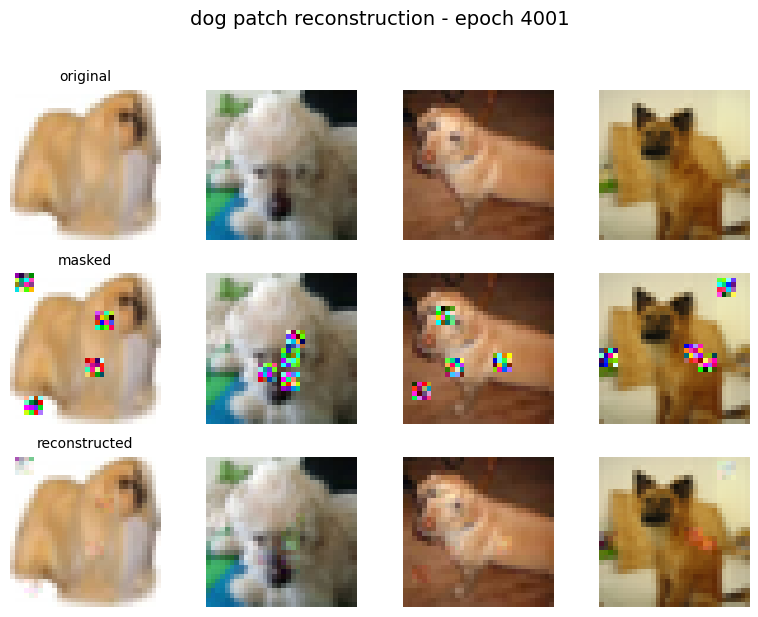

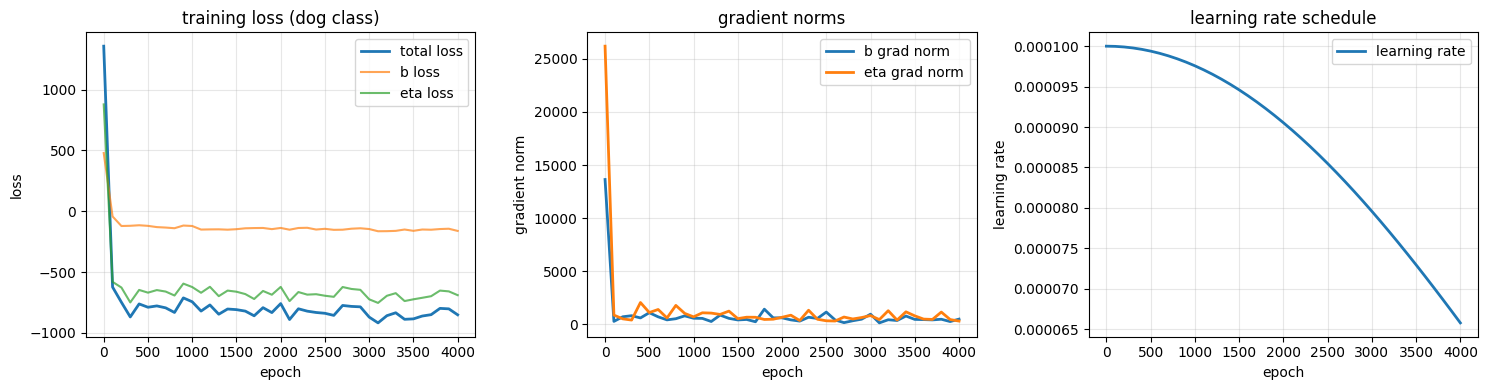

saved checkpoint at epoch 4001
epoch 4101: loss=-879.3011, b_loss=-159.2323, eta_loss=-720.0688
epoch 4201: loss=-932.8325, b_loss=-155.8543, eta_loss=-776.9783
epoch 4301: loss=-786.6998, b_loss=-139.5449, eta_loss=-647.1549
epoch 4401: loss=-892.9899, b_loss=-148.3443, eta_loss=-744.6456


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7579932..1.4916371].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3749639..2.057198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30927813..0.9098039].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89164805..1.6595563].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68863285..2.0133524].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.049047947..0.95577717].


epoch 4501: loss=-906.9656, b_loss=-159.1138, eta_loss=-747.8518

epoch: 4501


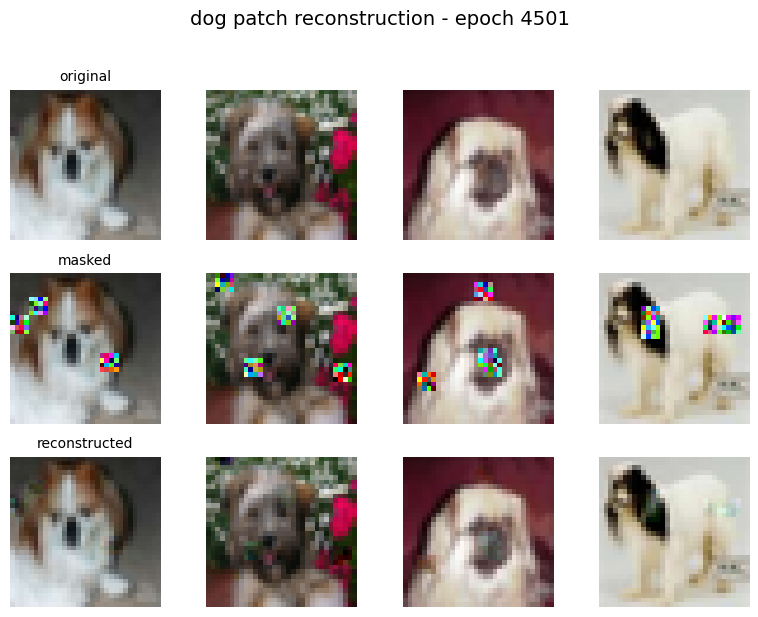

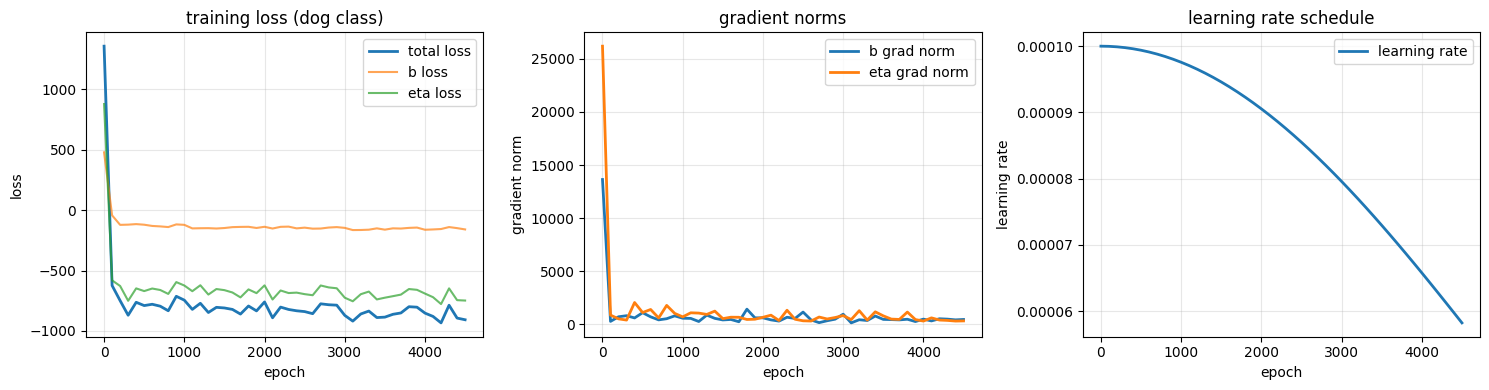

saved checkpoint at epoch 4501
epoch 4601: loss=-933.1879, b_loss=-155.3181, eta_loss=-777.8699
epoch 4701: loss=-841.2431, b_loss=-147.5229, eta_loss=-693.7202
epoch 4801: loss=-819.2576, b_loss=-154.1118, eta_loss=-665.1458
epoch 4901: loss=-882.8010, b_loss=-159.8017, eta_loss=-722.9993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5249623..1.7214417].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.168564..1.8935995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73213804..1.590179].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63868..1.780743].


epoch 5001: loss=-809.9426, b_loss=-147.0562, eta_loss=-662.8865

epoch: 5001


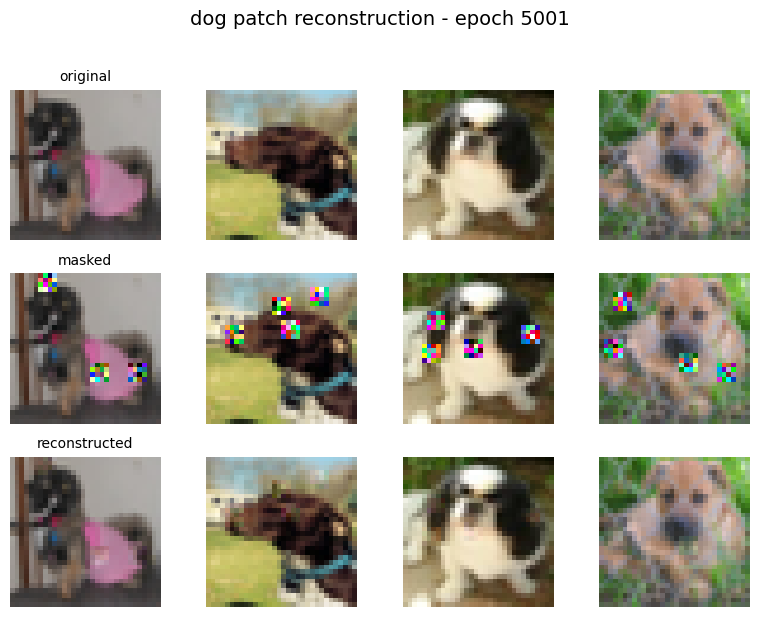

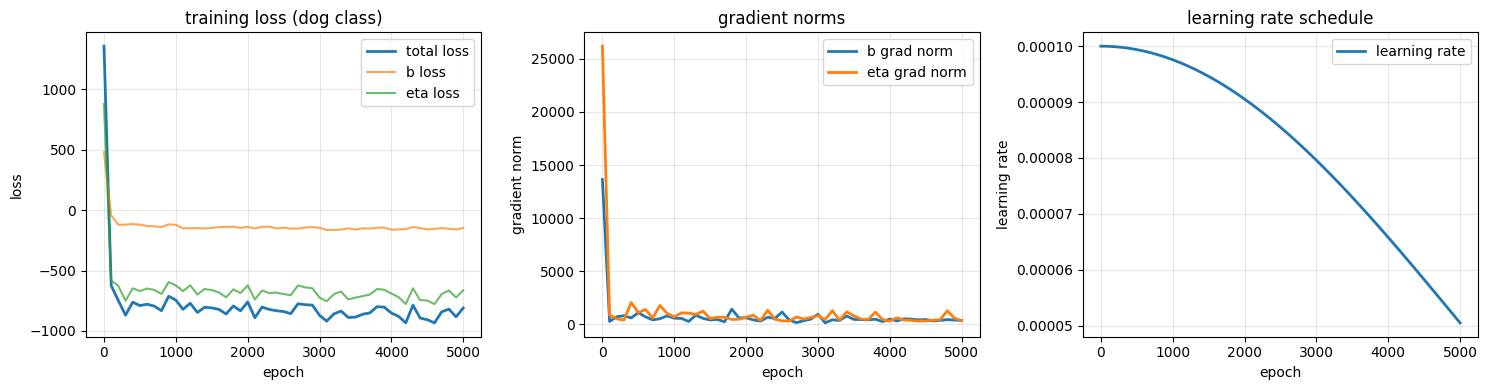

saved checkpoint at epoch 5001
epoch 5101: loss=-874.3395, b_loss=-156.8774, eta_loss=-717.4621
epoch 5201: loss=-781.3655, b_loss=-153.6841, eta_loss=-627.6815
epoch 5301: loss=-758.4120, b_loss=-134.7445, eta_loss=-623.6675
epoch 5401: loss=-852.9159, b_loss=-162.2562, eta_loss=-690.6597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75633824..2.16722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20823109..1.0356088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.87433267..1.8779204].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61174023..1.9325745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9526795..1.7000846].


epoch 5501: loss=-913.4495, b_loss=-163.1944, eta_loss=-750.2550

epoch: 5501


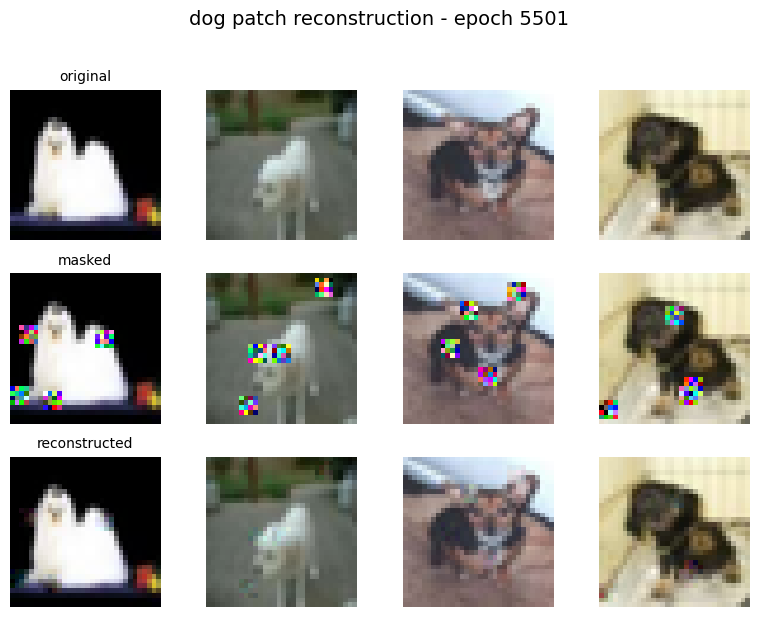

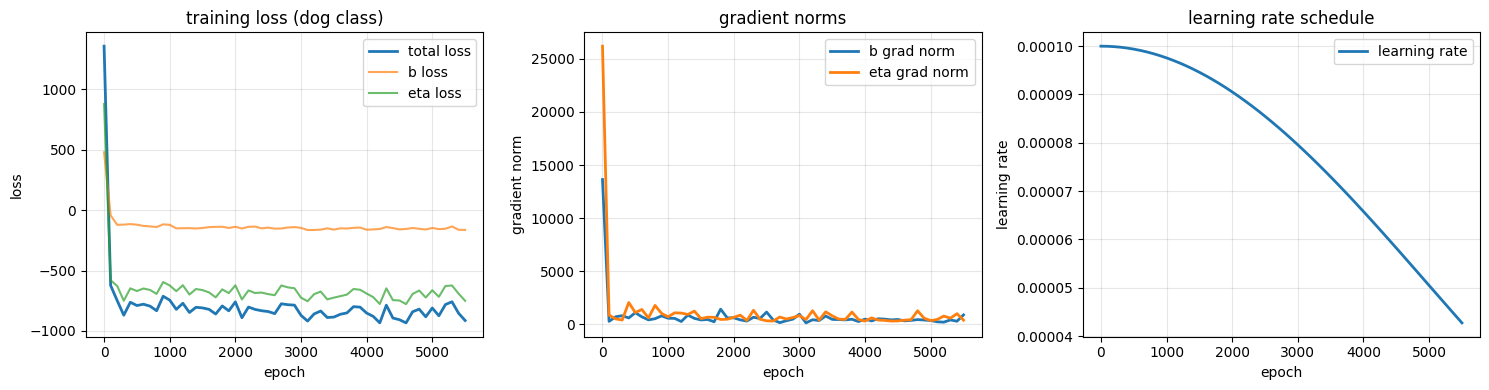

saved checkpoint at epoch 5501
epoch 5601: loss=-869.4488, b_loss=-156.7081, eta_loss=-712.7407
epoch 5701: loss=-899.6533, b_loss=-160.5526, eta_loss=-739.1008
epoch 5801: loss=-867.4594, b_loss=-163.1179, eta_loss=-704.3415
epoch 5901: loss=-876.7032, b_loss=-155.3520, eta_loss=-721.3513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.020319..1.8318176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013811171..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74299526..1.6394582].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.375302..1.9754031].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0711..0.7294118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9018637..1.7149967].


epoch 6001: loss=-866.4924, b_loss=-164.1509, eta_loss=-702.3416

epoch: 6001


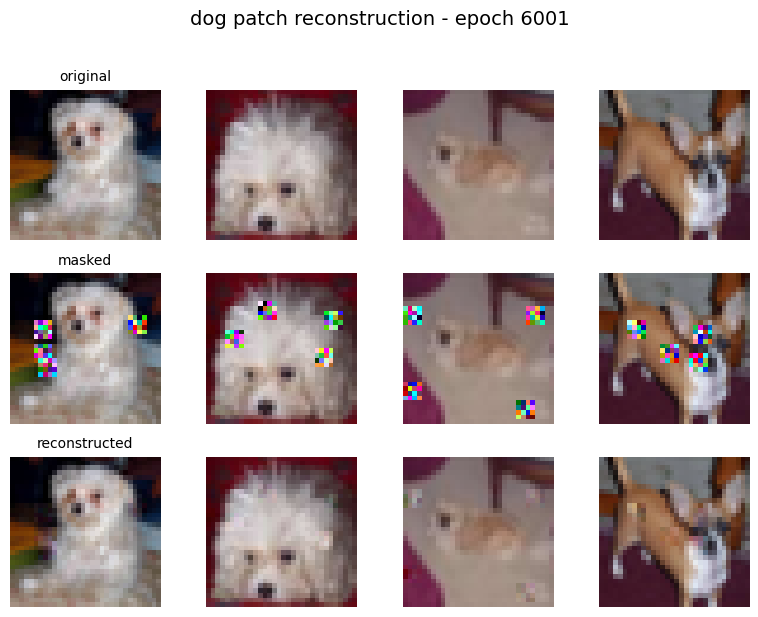

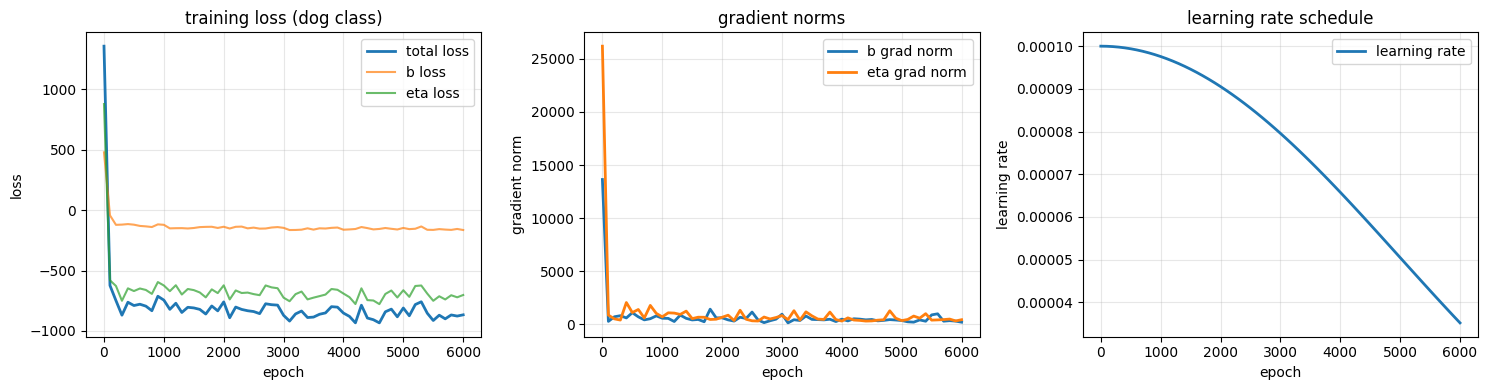

saved checkpoint at epoch 6001
epoch 6101: loss=-834.0447, b_loss=-145.9975, eta_loss=-688.0472
epoch 6201: loss=-824.2415, b_loss=-151.6894, eta_loss=-672.5521
epoch 6301: loss=-895.2117, b_loss=-163.9826, eta_loss=-731.2291
epoch 6401: loss=-871.9487, b_loss=-165.7686, eta_loss=-706.1802


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6010816..1.6734455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8554169..1.8846068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019644916..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77595055..2.2270036].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88645124..1.5969151].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.044387817..0.7529412].


epoch 6501: loss=-785.1962, b_loss=-149.7662, eta_loss=-635.4301

epoch: 6501


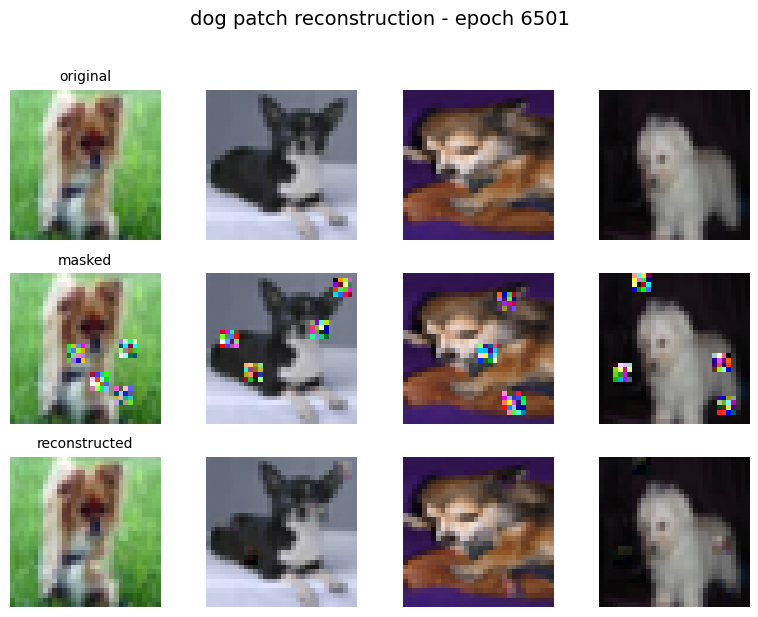

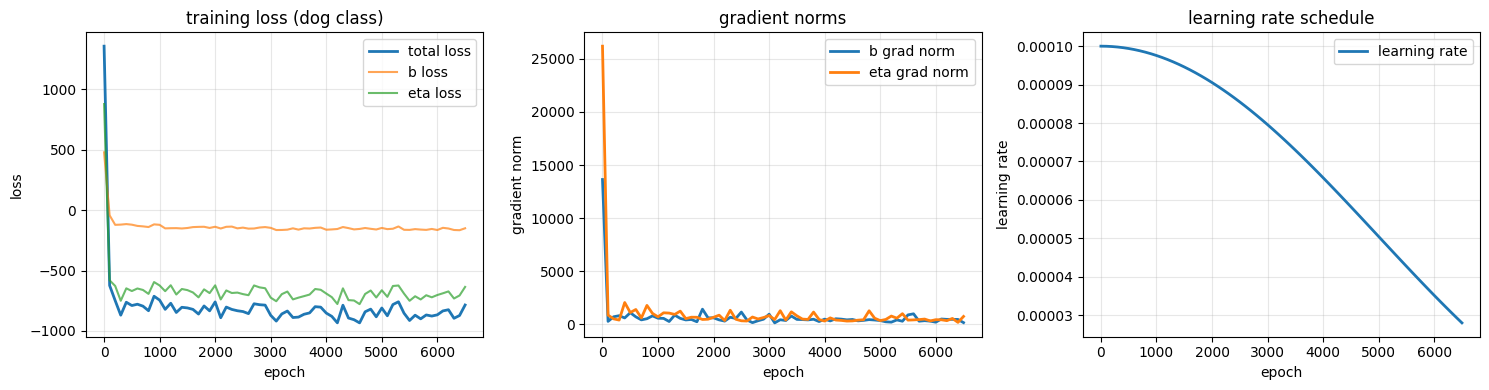

saved checkpoint at epoch 6501
epoch 6601: loss=-915.8235, b_loss=-159.4716, eta_loss=-756.3519
epoch 6701: loss=-749.4560, b_loss=-140.9014, eta_loss=-608.5546
epoch 6801: loss=-1053.3068, b_loss=-166.0708, eta_loss=-887.2359
epoch 6901: loss=-794.8682, b_loss=-149.6469, eta_loss=-645.2213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8357712..1.955444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0816153..2.133295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7350116..1.9571971].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.058204..1.890545].


epoch 7001: loss=-849.0880, b_loss=-159.0956, eta_loss=-689.9924

epoch: 7001


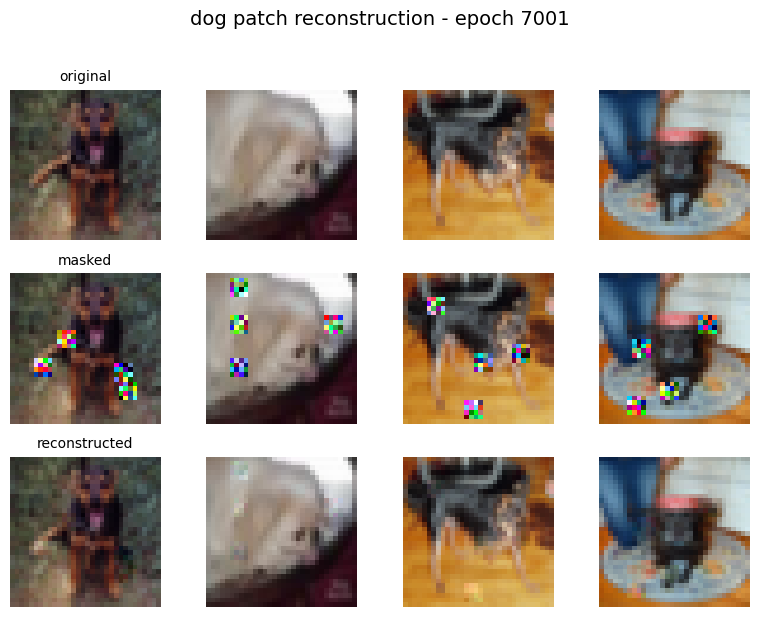

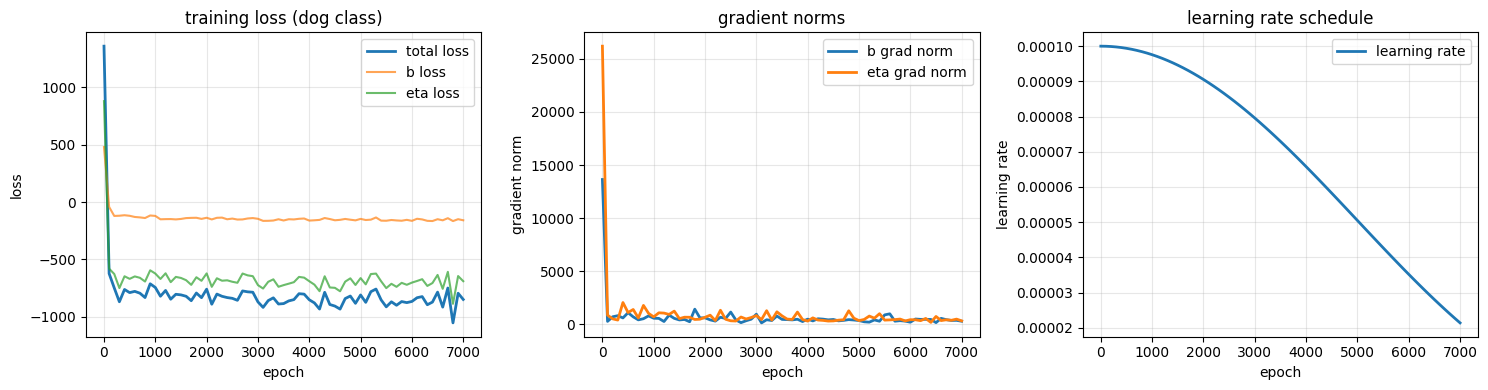

saved checkpoint at epoch 7001
epoch 7101: loss=-957.0713, b_loss=-176.3165, eta_loss=-780.7548
epoch 7201: loss=-876.9622, b_loss=-162.1826, eta_loss=-714.7795
epoch 7301: loss=-789.2646, b_loss=-152.5452, eta_loss=-636.7194
epoch 7401: loss=-804.9192, b_loss=-162.0304, eta_loss=-642.8888


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0531427..1.8813243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74860334..1.7252216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84058523..1.6875482].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76564264..1.7663234].


epoch 7501: loss=-799.1003, b_loss=-151.2178, eta_loss=-647.8825

epoch: 7501


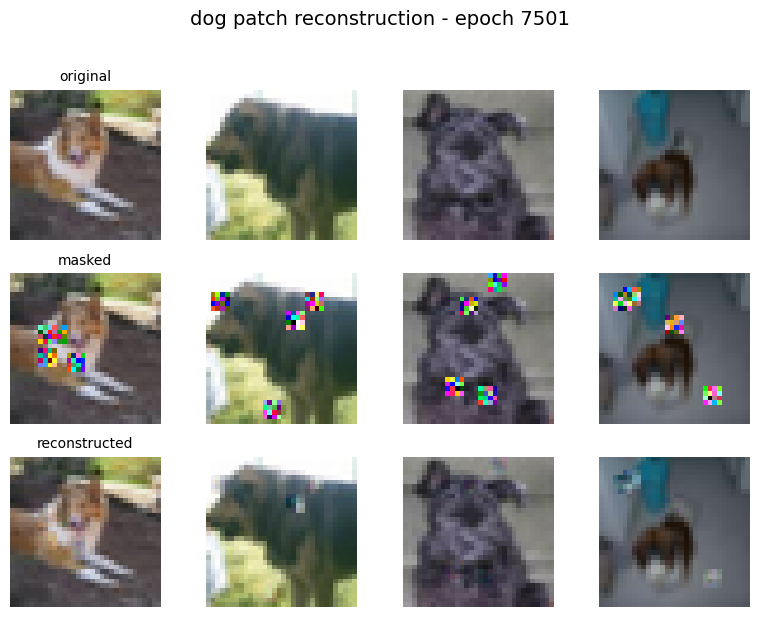

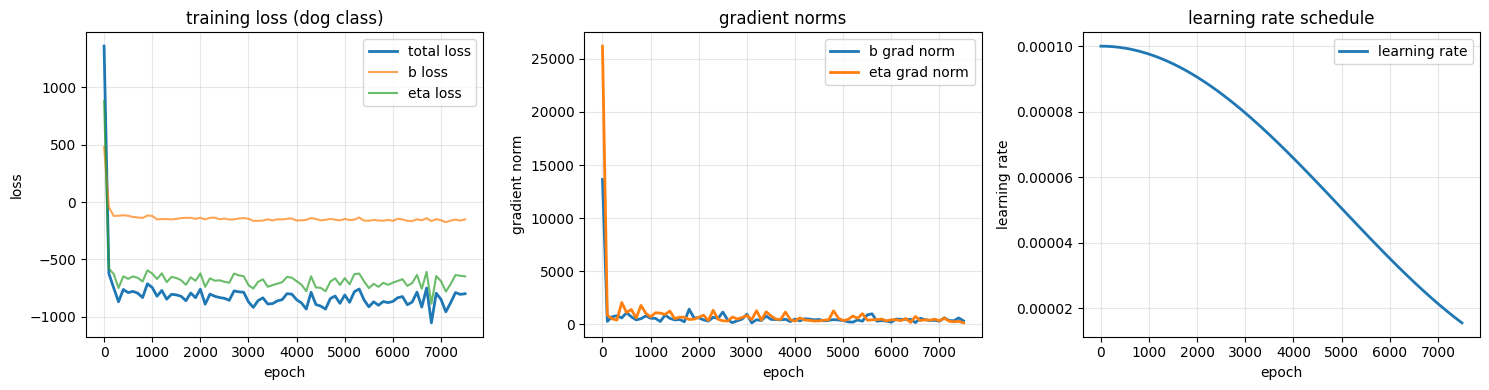

saved checkpoint at epoch 7501
epoch 7601: loss=-864.0243, b_loss=-151.8192, eta_loss=-712.2050
epoch 7701: loss=-825.4810, b_loss=-156.2647, eta_loss=-669.2163
epoch 7801: loss=-948.1613, b_loss=-165.1648, eta_loss=-782.9965
epoch 7901: loss=-904.9987, b_loss=-164.3090, eta_loss=-740.6897


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1633142..1.6562766].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08625269..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89594376..1.6006984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7094897..2.0084157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.83119345..1.9278699].


epoch 8001: loss=-871.5595, b_loss=-163.5169, eta_loss=-708.0426

epoch: 8001


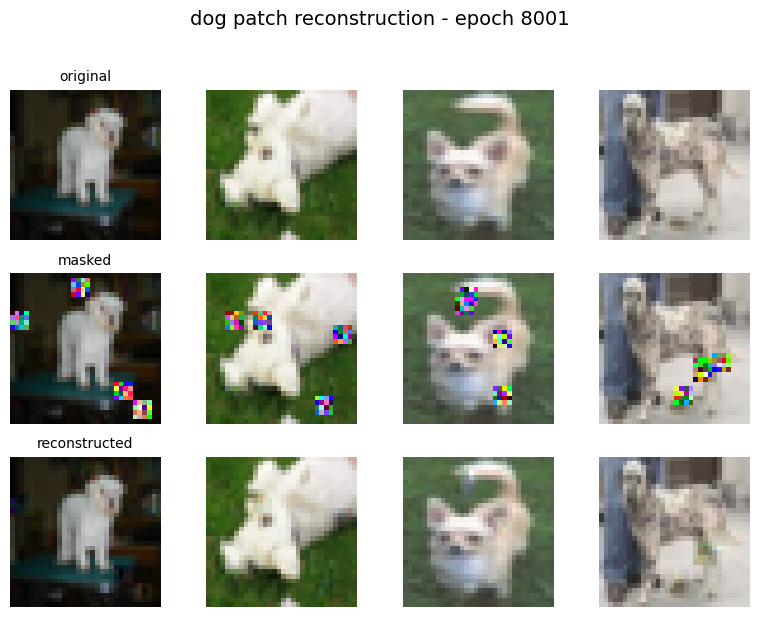

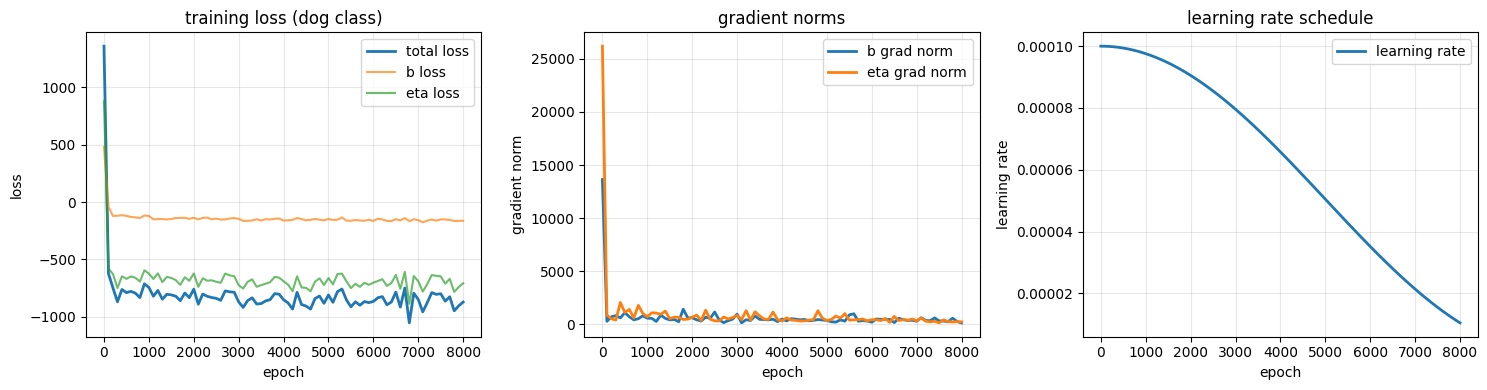

saved checkpoint at epoch 8001
epoch 8101: loss=-863.3131, b_loss=-154.2001, eta_loss=-709.1130
epoch 8201: loss=-814.7582, b_loss=-158.4566, eta_loss=-656.3016
epoch 8301: loss=-869.3843, b_loss=-151.7022, eta_loss=-717.6821
epoch 8401: loss=-870.2491, b_loss=-161.9620, eta_loss=-708.2872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7316456..2.1807709].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1067089..1.7497846].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8579087..1.6336266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13890213..0.9882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9202478..1.9697049].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.003124535..1.0478196].


epoch 8501: loss=-817.4473, b_loss=-157.6056, eta_loss=-659.8417

epoch: 8501


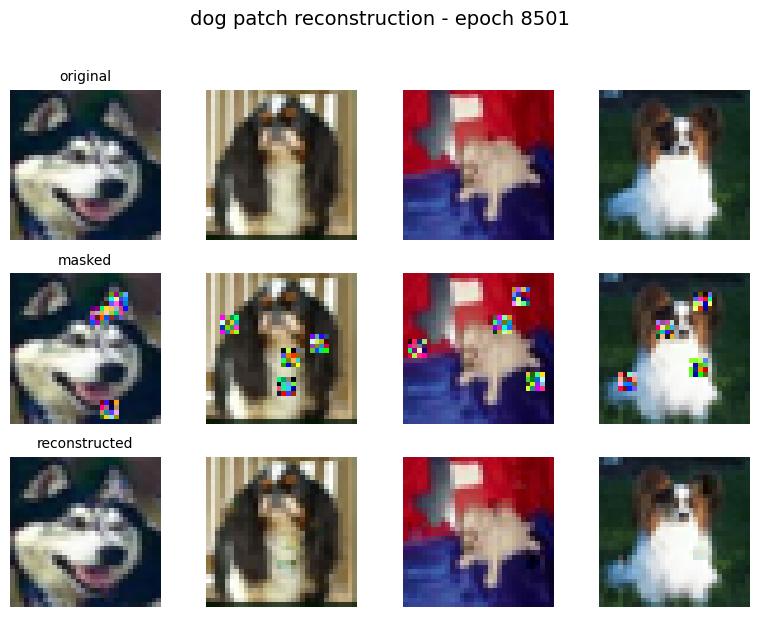

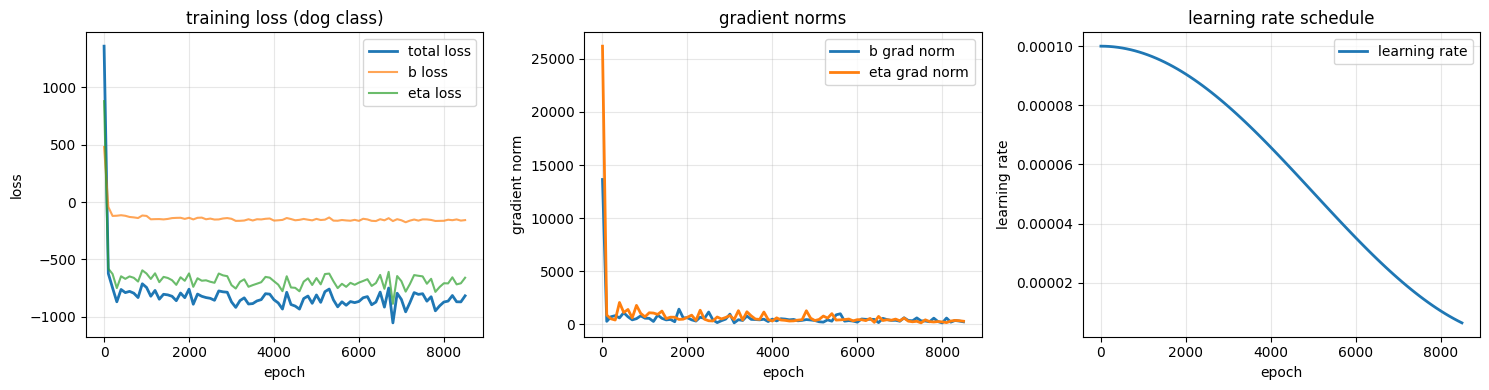

saved checkpoint at epoch 8501
epoch 8601: loss=-984.4016, b_loss=-156.4257, eta_loss=-827.9759
epoch 8701: loss=-842.1520, b_loss=-155.9742, eta_loss=-686.1779
epoch 8801: loss=-943.6295, b_loss=-172.6152, eta_loss=-771.0142
epoch 8901: loss=-897.1168, b_loss=-158.5880, eta_loss=-738.5287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7065129..1.7512399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06666666..1.006882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0264995..1.5593398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91108835..1.7210349].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1456224..1.7048585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.043137252..1.0396824].


epoch 9001: loss=-852.2569, b_loss=-153.5699, eta_loss=-698.6870

epoch: 9001


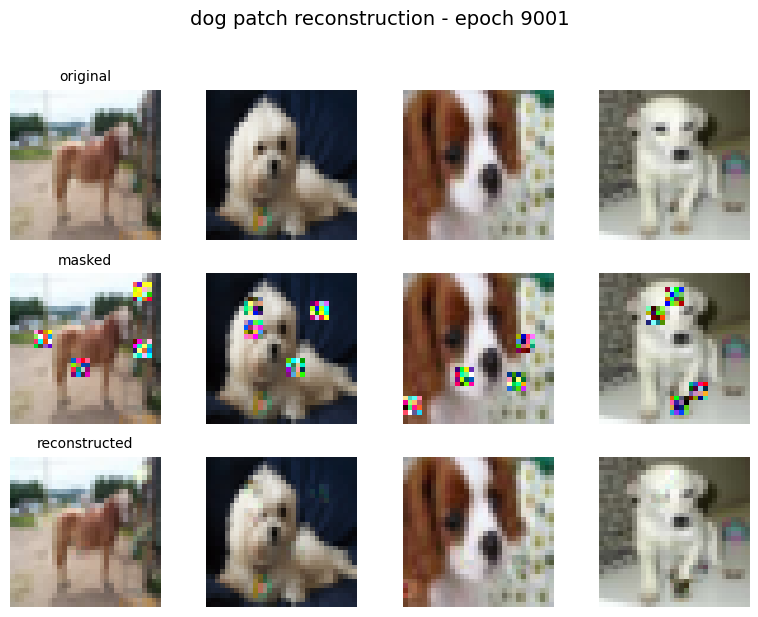

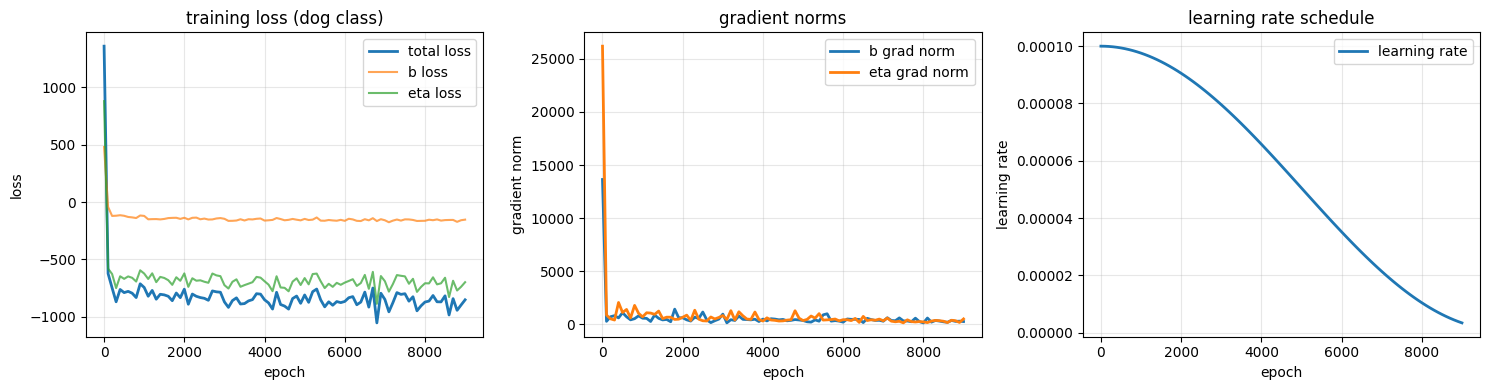

saved checkpoint at epoch 9001
epoch 9101: loss=-877.0449, b_loss=-154.8473, eta_loss=-722.1976
epoch 9201: loss=-831.6463, b_loss=-155.5611, eta_loss=-676.0851
epoch 9301: loss=-909.0531, b_loss=-161.7182, eta_loss=-747.3348
epoch 9401: loss=-836.3411, b_loss=-149.7607, eta_loss=-686.5804


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.333111..1.8809948].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7867832..1.9252902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.057920635..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0450066..1.9030588].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66452..1.719903].


epoch 9501: loss=-895.7974, b_loss=-168.5553, eta_loss=-727.2421

epoch: 9501


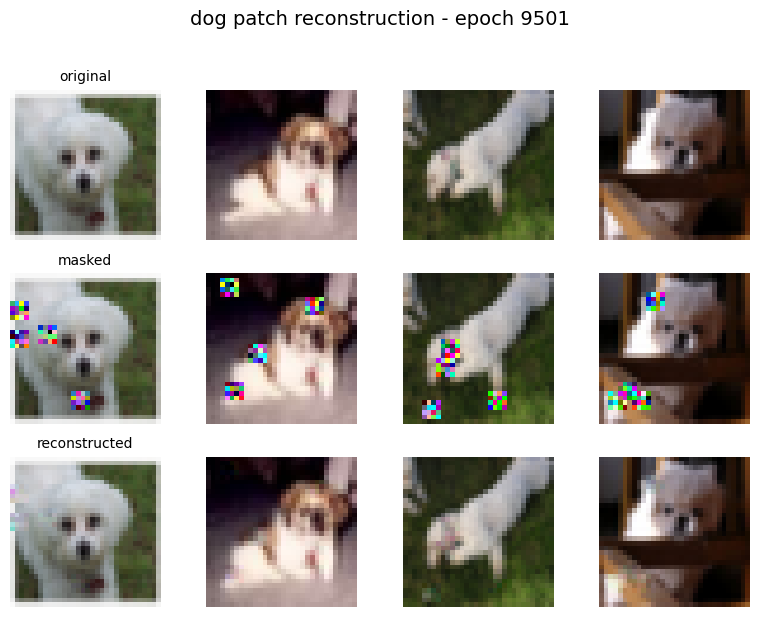

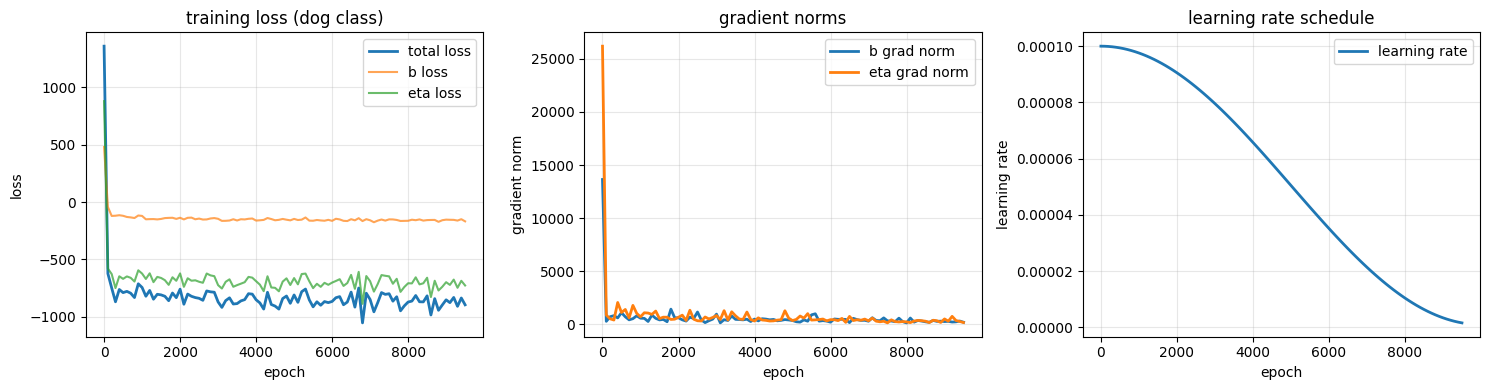

saved checkpoint at epoch 9501
epoch 9601: loss=-837.2848, b_loss=-157.8491, eta_loss=-679.4357
epoch 9701: loss=-818.8101, b_loss=-151.0813, eta_loss=-667.7288
epoch 9801: loss=-818.0695, b_loss=-154.9857, eta_loss=-663.0837
epoch 9901: loss=-827.1724, b_loss=-160.2653, eta_loss=-666.9072

training complete!


In [16]:
if __name__ == "__main__":
    # we set hyperparameters
    base_lr = 1e-4
    batch_size = 32
    n_epochs = 10000
    patch_size = 4
    num_patches = 4
    metrics_freq = 100
    plot_freq = 500
    
    print(f"\nhyperparameters:")
    print(f"  class: dog (cifar10 class 5)")
    print(f"  batch_size: {batch_size}")
    print(f"  learning_rate: {base_lr}")
    print(f"  n_epochs: {n_epochs}")
    print(f"  patch_size: {patch_size}")
    print(f"  num_patches: {num_patches}")
    print(f"\nconditioning approach:")
    print(f"  - networks conditioned on binary mask (visible=1, masked=0)")
    print(f"  - visible pixels kept fixed during generation")
    print(f"  - only masked regions are reconstructed")
    
    # we define interpolant (one-sided linear interpolation)
    path = 'one-sided-linear'
    interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type=None)
    print(f"\nusing interpolant: {path}")
    
    # we define loss functions
    loss_fn_b = stochastic_interpolant.make_loss(
        method='shared', interpolant=interpolant, loss_type='one-sided-b'
    )
    loss_fn_eta = stochastic_interpolant.make_loss(
        method='shared', interpolant=interpolant, loss_type='one-sided-eta'
    )
    
    # we create networks
    print("\ncreating u-net architectures with mask conditioning...")
    unet_b = UNetDenoiser(in_channels=5, out_channels=3, base_channels=64)  # we add mask channel
    unet_eta = UNetDenoiser(in_channels=5, out_channels=3, base_channels=64)  # we add mask channel
    
    b = VelocityNetwork(unet_b).to(itf.util.get_torch_device())
    eta = EtaNetwork(unet_eta).to(itf.util.get_torch_device())
    
    # we count parameters
    n_params_b = sum(p.numel() for p in b.parameters() if p.requires_grad)
    n_params_eta = sum(p.numel() for p in eta.parameters() if p.requires_grad)
    print(f"b network parameters: {n_params_b:,}")
    print(f"eta network parameters: {n_params_eta:,}")
    
    # we create optimizers and schedulers
    opt_b = torch.optim.Adam(b.parameters(), lr=base_lr)
    opt_eta = torch.optim.Adam(eta.parameters(), lr=base_lr)
    sched_b = torch.optim.lr_scheduler.CosineAnnealingLR(opt_b, T_max=n_epochs, eta_min=base_lr*0.01)
    sched_eta = torch.optim.lr_scheduler.CosineAnnealingLR(opt_eta, T_max=n_epochs, eta_min=base_lr*0.01)
    
    # we initialize data dictionary
    data_dict = {
        'losses': [],
        'b_losses': [],
        'eta_losses': [],
        'b_grads': [],
        'eta_grads': [],
        'lrs': []
    }
    
    # we train the model
    print("\nstarting training...\n")
    counter = 1
    for epoch in range(n_epochs):
        loss, b_loss, eta_loss, b_grad, eta_grad = train_step(
            batch_size, interpolant, opt_b, opt_eta, sched_b, sched_eta,
            patch_size, num_patches
        )
        
        # we log metrics
        if (counter - 1) % metrics_freq == 0:
            data_dict['losses'].append(grab(loss).item())
            data_dict['b_losses'].append(grab(b_loss).item())
            data_dict['eta_losses'].append(grab(eta_loss).item())
            data_dict['b_grads'].append(grab(b_grad).item())
            data_dict['eta_grads'].append(grab(eta_grad).item())
            data_dict['lrs'].append(opt_b.param_groups[0]['lr'])
            
            print(f"epoch {counter}: loss={grab(loss).item():.4f}, b_loss={grab(b_loss).item():.4f}, eta_loss={grab(eta_loss).item():.4f}")
        
        # we make plots
        if (counter - 1) % plot_freq == 0:
            make_plots(b, eta, interpolant, counter, data_dict, patch_size, num_patches)
            
            # we save checkpoints
            torch.save({
                'epoch': counter,
                'b_state_dict': b.state_dict(),
                'eta_state_dict': eta.state_dict(),
                'opt_b_state_dict': opt_b.state_dict(),
                'opt_eta_state_dict': opt_eta.state_dict(),
                'data_dict': data_dict,
                'class': 'dog',
                'class_id': 5
            }, f'dog_checkpoint_epoch_{counter}.pt')
            print(f"saved checkpoint at epoch {counter}")
        
        counter += 1
    
    print("\ntraining complete!")